In [14]:
from ase.io.cube import read_cube_data
import pandas as pd
import numpy as np
from ase import Atoms
from ase.visualize import view
import math
import matplotlib.pyplot as plt
import os
                      

In [58]:
#calculate freezing distancce of 3000eV Na scattered from InAs at 125º
#the projectile comes out in surface normal direction

def freezingDistance(E,theta,spicie,sc):
    
    m1 = M['Na']
    m2 = M[spicie]
    
    E = E*((m1*np.cos(sc/180*np.pi)+np.sqrt(m2**2-(m1*np.sin(sc/180*np.pi))**2))/(m1+m2))**2
    #print (E)
    v=math.sqrt(8389769*E)*math.cos(theta/180*np.pi)
    #print(v/2187691)
    d=1/0.86*math.log(2*2.23/(0.86*v/2187691))*0.53
    return round(d,2)


# determine the potential at any XYZ
def potential(X,Y,Z,data,offset):
    #convert XYZ to within boundary first
    
    while  X<0: 
        X+=cellX 
    while  X>cellX: 
        X-=cellX
    while  Y<0: 
        Y+=cellY 
    while  Y>cellY: 
        Y-=cellY
    
    X,Y,Z = int(X/dx),int(Y/dy),int(Z/dz)
    
    return round(data[X][Y][Z]- offset,3) 

def fzpotential(row,data,offset):
    X,Y,Z = row['x'],row['y'],row['z']
    zf = freeze_In if row['atom'] == 'In' else freeze_As  
    
    return potential(X,Y,Z+zf,data,offset)

# determine the potential above each atom
def potential_vs_z(row,Zrange,azi,theta,data,offset):
    
    X,Y,Z = row['x'],row['y'],row['z']
    
    cx = math.sin(theta/180*np.pi)*math.cos(azi/180*np.pi)
    cy = math.sin(theta/180*np.pi)*math.sin(azi/180*np.pi)
    cz = math.cos(theta/180*np.pi)
    #print (cx,cy,cz)
    
    p_vs_z=[]
    
    for delta_z in Zrange: 
        ddx,ddy,ddz = delta_z*cx,delta_z*cy,delta_z*cz
        p_vs_z+=[potential(X+ddx,Y+ddy,Z+ddz,data,offset)]
    return p_vs_z 

# determine the average potential above each atom
def avg_potential_vs_z(row,Zrange,azi,theta,data,offset,r):
    X,Y,Z = row['x'],row['y'],row['z']
    Z0 = row['Z0']
    avg_p_z=[]
    
    XYpairs=[]
    for delta_x in np.linspace(-r,r,9):
        for delta_y in np.linspace(-r, r, 9):
            if np.abs(delta_x+delta_y*1.j)<=r:
                PX,PY=X+delta_x,Y+delta_y
                XYpairs+=[(PX,PY)]
    
    cx = math.sin(theta/180*np.pi)*math.cos(azi/180*np.pi)
    cy = math.sin(theta/180*np.pi)*math.sin(azi/180*np.pi)
    cz = math.cos(theta/180*np.pi)
    
    for delta_z in Zrange: 
        ddx,ddy,ddz = delta_z*cx,delta_z*cy,delta_z*cz
        
        p_tot = []
        for PX,PY in XYpairs:
            p_tot.append(potential(PX+ddx,PY+ddy,Z+ddz,data,offset))
        
        avg_p_z+=[round(np.mean(p_tot),2)]
    #print(avg_p_z)
    return avg_p_z 

In [16]:
def Z0(row,atomxyz):
    X,Y,Z = row['x'],row['y'],row['z']
    Z0 = Z
    for x,y,z in atomxyz:
        if min(abs(x-X),cellX-abs(x-X))**2+min(abs(y-Y),cellY-abs(y-Y))**2<=tempr2:
            Z0 = max(Z0,z)
    
    return Z0+1

In [17]:
#use RCT model to determine NF scattered from each site
def potential_NF(potential,vmax,zf,Z0,Z):
    if Z+zf<Z0:
        dE = 0
    #calculate s level after shifting 
    else:
        dE = 27.2/math.sqrt((27.2*27.2)/(vmax*vmax) + 16*(zf/0.53)**2)
    Es = -5.14+dE
    #print(Es)
    
    #calculating broadening of the s level
    broad = 27.2*2.23/math.sqrt(math.sqrt(math.exp(4*0.86*zf/0.53)+(2.23/0.04)**4-1))
    
    #guassion integral
    sigma = broad/1.38629
    NF = (0.5+0.5*math.erf((potential-Es)/(1.414*sigma)))
    
    return round(NF*100,1) #NF in %

In [18]:
# some constants
vmax = 2.6
r=0    #radius of the avarage area
theta = 0
Zrange = np.linspace(0,4,20) 
E0 = 3000
sc = 125
M = {'Na': 22.99,'In':114.82,'As':74.92}

freeze_As=freezingDistance(E0,theta,"As",sc)*0.95#freezing distance from As
freeze_In=freezingDistance(E0,theta,"In",sc)*0.95#freezing distance from In

potential=-3.9
for p in [potential,potential-0.9,potential-0.4]:
    NF_As = potential_NF(p,vmax,freeze_As,1,freeze_As)
    NF_In = potential_NF(p,vmax,freeze_In,1,freeze_In)
    print(NF_As,NF_In)



57.3 53.7
3.7 5.3
24.5 25.2


In [19]:
def NF(row,vmax):
    zf = freeze_In if row['atom'] == 'In' else freeze_As  
    potential = row['fz_potential']
    Z0,Z = row['Z0'],row['z']
    
    return potential_NF(potential,vmax,zf,Z0,Z)

In [20]:
def NF_vs_z(row,Zrange,azi,vmax):
    
    NFs=[]
    Z = row['z']
    Z0 = row['Z0']
    for i,zf in enumerate(Zrange):
        Ei = row[str(azi)+'_avg_p_vs_z'][i]
        NFs += [potential_NF(Ei,vmax,zf,Z0,Z)] 
    return NFs

In [21]:
def vs_z_plot(Zrange,atomdf,azi,col):
    
    if azi==0:
        for i in visible_0_As.index:
            plt.plot(Zrange,atomdf.loc[i][col],'-',label='As'+str(i))
        for i in visible_0_In.index:
            plt.plot(Zrange,atomdf.loc[i][col],'--', label='In'+str(i))
    
    else:
        for i in visible_90_As.index:
            plt.plot(Zrange,atomdf.loc[i][col],'-',label='As'+str(i))
        for i in visible_90_In.index:
            plt.plot(Zrange,atomdf.loc[i][col],'--',label='In'+str(i))
    
    
    plt.legend(loc='best')
    #plt.savefig(dataname[:4]+col)

In [22]:
def NF_avg_plot(atomdf,azi):
    NFs_As = []
    NFs_In = []
    NF_As_fz = 0
    NF_In_fz = 0
    if azi == 0:
        for i in visible_0_As.index:
            NFs_As += [np.asarray(atomdf.loc[i]['0_NF_vs_z'])*visible_0_As.loc[i]]
            NF_As_fz += atomdf.loc[i]['NF']*visible_0_As.loc[i]
            
        for i in visible_0_In.index:
            NFs_In += [np.asarray(atomdf.loc[i]['0_NF_vs_z'])*visible_0_In.loc[i]]
            NF_In_fz += atomdf.loc[i]['NF']*visible_0_In.loc[i]
    else:
        for i in visible_90_As.index:
            NFs_As += [np.asarray(atomdf.loc[i]['90_NF_vs_z'])*visible_90_As.loc[i]]
            NF_As_fz += atomdf.loc[i]['NF']*visible_90_As.loc[i]
        for i in visible_90_In.index:
            NFs_In += [np.asarray(atomdf.loc[i]['90_NF_vs_z'])*visible_90_In.loc[i]]
            NF_In_fz += atomdf.loc[i]['NF']*visible_90_In.loc[i]
            
    #print(NFs_As)
    #print(np.asarray(NFs_As).mean(axis=1))
    print( 'As:',round(NF_As_fz,2),'In:',round(NF_In_fz,2))
    NF_avg_As = np.asarray(NFs_As).sum(axis=0)
    NF_avg_In = np.asarray(NFs_In).sum(axis=0)    
    plt.plot(Zrange,NF_avg_As,'-',linewidth=5,label='As_avg')
    
    plt.plot(Zrange,NF_avg_In,'--',linewidth=5,label='In_avg')
    
    plt.legend(loc='best')

In [23]:
def exp_plot(ori):
        plt.axhline(y=expNF[str(ori)]['As'], color='b', linestyle='-')
        plt.axhline(y=expNF[str(ori)]['In'], color='g', linestyle='--')

        plt.axhspan(expNF[str(ori)]['As']-expNF[str(ori)]['As_e'],expNF[str(ori)]['As']+expNF[str(ori)]['As_e'],
                    color='b', linestyle='-', alpha = 0.1)
        plt.axhspan(expNF[str(ori)]['In']-expNF[str(ori)]['In_e'],expNF[str(ori)]['In']+expNF[str(ori)]['In_e'],
                    color='g', linestyle='--', alpha = 0.1)

In [24]:
def fermi_NF_plot(efermi,offset,vmax):
    
    NF_fermi_As = potential_NF(efermi-offset,vmax,freeze_As)
    NF_fermi_In = potential_NF(efermi-offset,vmax,freeze_In)
    print(NF_fermi_As,NF_fermi_In)
    
    plt.axhline(y=NF_fermi_As, color='r', linestyle='-')
    plt.axhline(y=NF_fermi_In, color='r', linestyle='--')

In [59]:
def readdata(dataname,Zrange,fermishift,vmax,theta,r,plotname):
    print(dataname)
    data,atoms=read_cube_data(dataname)

    offset = data.mean(axis=0).mean(axis=0).max() + fermishift  #potential at infinite far
    print('offset:',offset)
    
    atomxyz = atoms.get_positions()
    symbols = atoms.get_chemical_symbols()

    atomdf = pd.concat([pd.DataFrame(atomxyz,columns=['x', 'y', 'z']),
                        pd.DataFrame(symbols,columns=['atom'])],
                       axis=1)
    
    atomdf['Z0'] = atomdf.apply(Z0,atomxyz = atomxyz, axis=1)
    atomdf['fz_potential'] = atomdf.apply(fzpotential,data=data,offset=offset,axis=1)
    atomdf['NF'] = atomdf.apply(NF,vmax = vmax, axis=1)
    
    for azi in [0,90]:
        atomdf[str(azi)+'_p_vs_z'] = atomdf.apply(potential_vs_z,
                                          Zrange=Zrange,azi=azi,theta=theta,data=data,offset=offset,axis=1)
        
        atomdf[str(azi)+'_avg_p_vs_z']=atomdf.apply(avg_potential_vs_z,
                                                 Zrange=Zrange,azi=azi,theta=theta,data=data,offset=offset,r=r,axis=1)
        
        atomdf[str(azi)+'_NF_vs_z'] = atomdf.apply(NF_vs_z,Zrange=Zrange,azi=azi,vmax = vmax,axis=1)

    
    if plotname == 'NF_vs_z':
        plt.figure(figsize=(10,10))
        
        ax=plt.subplot(211)
        ax.axis([1, 4, 0, 100])
        #vs_z_plot(Zrange,atomdf,0,'0_NF_vs_z')
        NF_avg_plot(atomdf,0)
        exp_plot(0)
        #fermi_NF_plot(efermi,offset,vmax)
        plt.axvline(x=freeze_As,color='k', linestyle='-')
        plt.axvline(x=freeze_In,color='k', linestyle='--')
        ax.set_title(dataname[:4]+'0')

        ax2=plt.subplot(212)
        ax2.axis([1, 4, 0, 100])
        #vs_z_plot(Zrange,atomdf,90,'90_NF_vs_z')
        NF_avg_plot(atomdf,90)
        exp_plot(90)
        #fermi_NF_plot(efermi,offset,vmax)
        plt.axvline(x=freeze_As,color='k', linestyle='-')
        plt.axvline(x=freeze_In,color='k', linestyle='--')
        ax2.set_title(dataname[:4]+'90')
    
    else:
        plt.figure(figsize=(10,10))
        ax=plt.subplot(211)
        vs_z_plot(Zrange,atomdf,0,'0_'+plotname)
        ax.set_title(dataname[:4]+'0')

        ax2=plt.subplot(212)
        vs_z_plot(Zrange,atomdf,90,'90_'+plotname)
        ax2.set_title(dataname[:4]+'90')
    
    
    
    return atomdf,atoms

In [46]:
def scatterweight (target,ICISS):

    df = pd.read_table(target)
    X = list(df['rx'])
    Y = list(df['ry'])
    bx,by = max(X)-min(X),max(Y)-min(Y)
    print([bx,by])

    atom = pd.read_table(ICISS,delim_whitespace=True,names = ('x','y','z','Z','m','f'))

    #find the top unblocked atoms
    toplist = []    
    for index, row in atom.iterrows():
        k=0
        for a in toplist:
            rowa = atom.loc[a]
            if np.sqrt((rowa['x']-row['x'])**2+(rowa['y']-row['y'])**2)<0.4:
                if rowa['z']>row['z']:
                    k=1
                else:
                    toplist.remove(a)
        if k==0:
            toplist.append(index)
    print(toplist)

    counts = [0]*atom.shape[0]
    for x,y in zip(X,Y):
        dmin = 500
        index_min = -1
        for a in toplist:
            lx = abs(atom.loc[a]['x']-x)
            ly = abs(atom.loc[a]['y']-y)
            l = min(lx,bx-lx)**2+min(ly,by-ly)**2
            if  l < dmin:
                dmin = l
                index_min = a
        counts[index_min] += 1

    atom['count']=counts



    atom['sum'] = atom.groupby('Z')['count'].transform('sum')
    atom['perc'] = (atom['count']/atom['sum']).round(3)
    atom.head(10)


    topIn = atom.loc[toplist].query('Z ==49')
    topAs = atom.loc[toplist].query('Z ==33')
    In_X = list(topIn['x'])
    In_Y = list(topIn['y'])
    As_X = list(topAs['x'])
    As_Y = list(topAs['y'])
    plt.figure(figsize=(bx/2,by/2))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(X,Y,marker='.',label='scatter sites')
    plt.scatter(In_X,In_Y,marker='o',s=100,color='orange',label='In')
    plt.scatter(As_X,As_Y,marker='o',s=180,color='g',label='As')
    plt.axhline(0.00000,linestyle='--',color='grey')
    #plt.legend(bbox_to_anchor=(1.05, 1),fontsize=15)
    
    return topIn['perc'],topAs['perc']
    

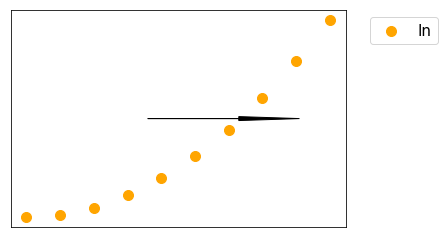

In [47]:
x=np.linspace(0,10,10)
y=x**2
plt.xticks([])
plt.yticks([])
plt.scatter(x,y,marker='o',s=100,color='orange',label='In')
plt.legend(bbox_to_anchor=(1.05, 1),fontsize=15)
plt.arrow(4, 50, 3, 0, head_width=2, head_length=2, fc='k', ec='k')

[8.541394, 17.075159]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 31, 32, 36, 41, 42, 45, 46]


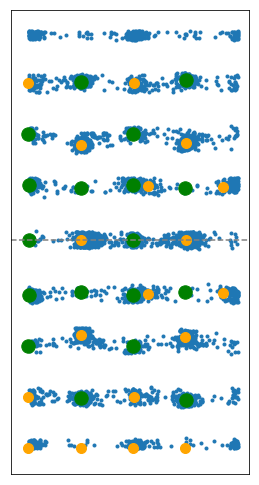

In [28]:
zetaA0_In,zetaA0_As = scatterweight ('dftzetaA0.txt','zetaA0.txt')

[17.082580999999998, 8.537579000000001]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 31, 32, 36, 41, 42, 45, 46]


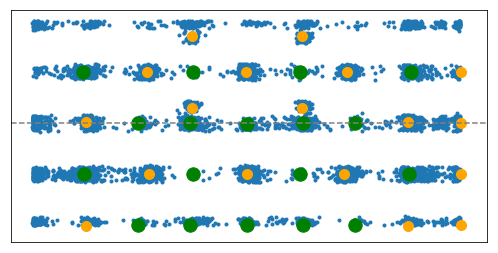

In [29]:
zetaA90_In,zetaA90_As = scatterweight ('dftzetaA90.txt','zetaA90.txt')

[8.517621000000002, 17.075158000000002]
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63]


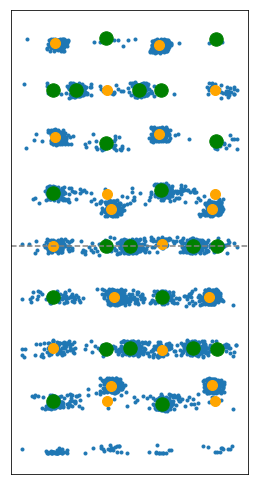

In [30]:
beta0_In,beta0_As = scatterweight ('dftbeta0.txt','beta0.txt')

[17.071229, 7.140985000000001]
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63]


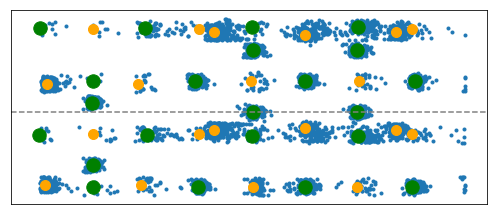

In [31]:
beta90_In,beta90_As = scatterweight ('dftbeta90.txt','beta90.txt')

2.7929999999999997 2.6885
zeta_A_potential.cube
offset: 5.131288292478354
As: 59.92 In: 48.12
As: 69.99 In: 43.72
beta_2_potential.cube
offset: 5.153590377164502
As: 68.22 In: 32.78
As: 53.39 In: 25.55


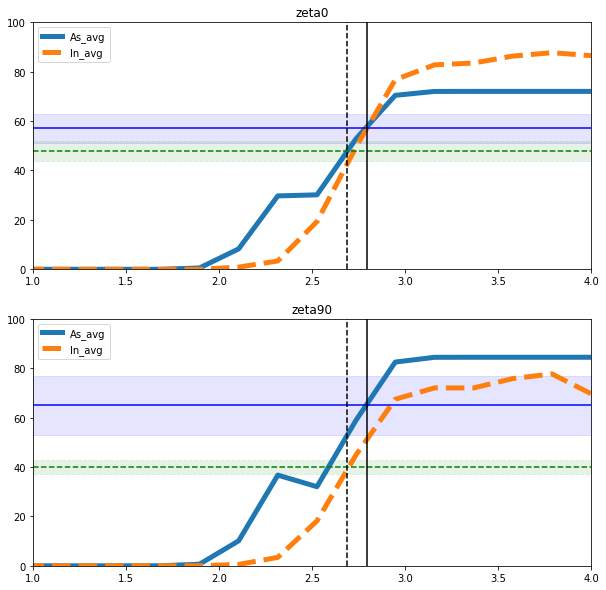

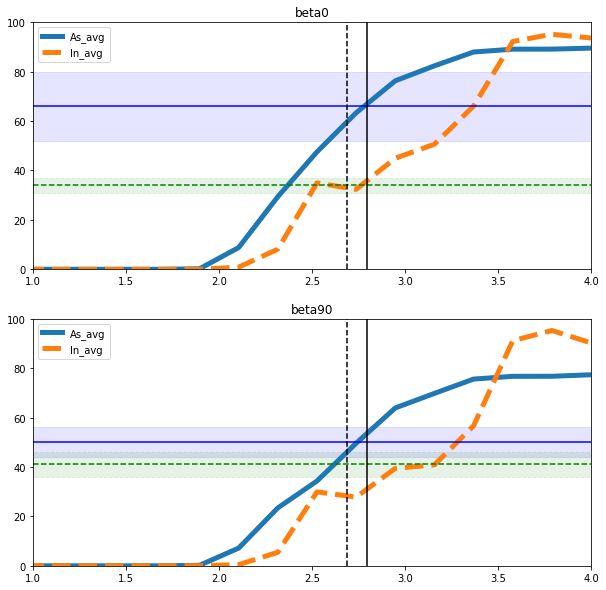

In [60]:
# some constants
vmax = 2.6
r=0    #radius of the avarage area
theta = 0
Zrange = np.linspace(0,4,20) 
E0 = 3000
sc = 125
M = {'Na': 22.99,'In':114.82,'As':74.92}

freeze_As=freezingDistance(E0,theta,"As",sc)*0.95#freezing distance from As
freeze_In=freezingDistance(E0,theta,"In",sc)*0.95#freezing distance from In
#freeze_As=3.0 #freezing distance from As
#freeze_In=3.0 #freezing distance from In

print(freeze_As,freeze_In)

dx,dy,dz = 8.54/44,17.08/84,25/124
cellX,cellY,cellZ=8.54, 17.08, 25.
tempr2=10
for file in os.listdir():
    if file.endswith(".cube"):
        
        if file=='zeta_A_potential.cube':
            visible_0_In,visible_0_As = zetaA0_In,zetaA0_As
            visible_90_In,visible_90_As = zetaA90_In,zetaA90_As
            efermi = - 0.2086
            wf = 5.24
            fermishift = 0.1
            expNF={'0':{'As':57,'In':48,'As_e':6,'In_e':4},'90':{'As':65,'In':40,'As_e':12,'In_e':3}}
            zetadf,zetaatom=readdata(file,Zrange,fermishift,vmax,theta,r,'NF_vs_z')
        if file=='beta_2_potential.cube':
            visible_0_In,visible_0_As = beta0_In,beta0_As
            visible_90_In,visible_90_As = beta90_In,beta90_As
            efermi = - 0.322
            wf = 5.38
            fermishift = 0.1
            expNF={'0':{'As':66,'In':34,'As_e':14,'In_e':3},'90':{'As':50,'In':41,'As_e':6,'In_e':5}}
            betadf,betaatom=readdata(file,Zrange,fermishift,vmax,theta,r,'NF_vs_z')
        #df=readdata(file,Zrange,fermishift,vmax,theta,r,'NF_vs_z')

In [ ]:
fermirange= np.linspace(-5,-2,30)
NF_As=[]
NF_In=[]
NF_As_2= []
NF_In_2= []
for f in fermirange:
    
    NF_As += [potential_NF(f,vmax,freeze_As)]
    NF_In += [potential_NF(f,vmax,freeze_In)]
    NF_As_2 += [potential_NF(f-0.3,vmax,freeze_As)]
    NF_In_2 += [potential_NF(f-0.3,vmax,freeze_In)]
    
plt.plot(fermirange, np.asarray(NF_As), color='r', linestyle='-')
plt.plot(fermirange, np.asarray(NF_In), color='r', linestyle='--')
plt.plot(fermirange, np.asarray(NF_As_2), color='g', linestyle='-')
plt.plot(fermirange, np.asarray(NF_In_2), color='g', linestyle='--')

In [24]:
view(zetaatom)

In [469]:
view(betaatom)

In [121]:
def compare_plot(Zrange,azi,col):
    
    
    if azi==0:
        for i in cp_zetadf:
            symbol=zetadf.loc[i]['atom']
            plt.plot(Zrange,zetadf.loc[i][str(azi)+col],'-',label=symbol+str(i))
        for i in cp_betadf:
            symbol=betadf.loc[i]['atom']
            plt.plot(Zrange,betadf.loc[i][str(azi)+col],'--', label=symbol+str(i))
    
    else:
        for i in cp_zetadf:
            symbol=zetadf.loc[i]['atom']
            plt.plot(Zrange,zetadf.loc[i][str(azi)+col],'-',label=symbol+str(i))
        for i in cp_betadf:
            symbol=betadf.loc[i]['atom']
            plt.plot(Zrange,betadf.loc[i][str(azi)+col],'--',label=symbol+str(i))
    
    #plt.axis([2, 4, -10, 0])
    #plt.legend(loc='best')
    #plt.savefig(dataname[:4]+col)

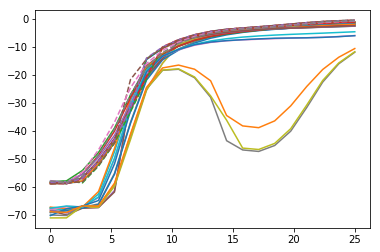

In [124]:
cp_zetadf = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
cp_betadf = [6,7,8,9,46,47]
compare_plot(np.linspace(0,25,20),0,'_p_vs_z')

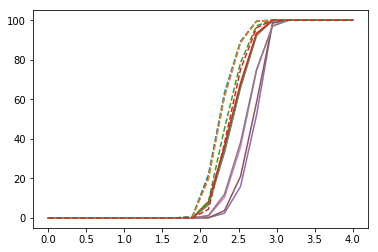

In [29]:
for i in cp_zetadf:
    plt.plot(Zrange,zetadf.loc[i]['0_NF_vs_z'],'-',label='As'+str(i))
for i in cp_betadf:
    plt.plot(Zrange,betadf.loc[i]['0_NF_vs_z'],'--',label='As'+str(i))

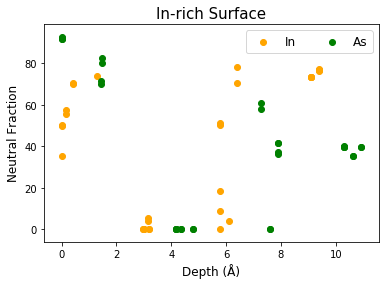

In [84]:
plt.scatter(zetadf[zetadf['atom']=='In']['Z0']-zetadf[zetadf['atom']=='In']['z']-1,zetadf[zetadf['atom']=='In']['NF'],color='orange',label="In")
plt.scatter(zetadf[zetadf['atom']=='As']['Z0']-zetadf[zetadf['atom']=='As']['z']-1,zetadf[zetadf['atom']=='As']['NF'],color='g',label="As")
plt.title('In-rich Surface',fontsize=15,fontweight=200)
plt.ylabel('Neutral Fraction',fontsize=12)
plt.xlabel('Depth (Å)',fontsize=12)#fontweight='bold',)
plt.legend(loc='upper right',fontsize=12,ncol=2)

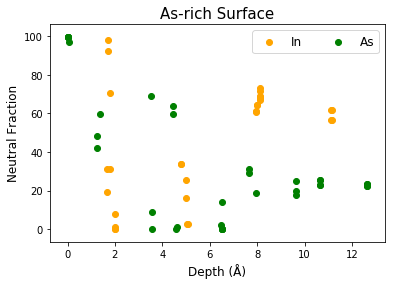

In [85]:
plt.scatter(betadf[betadf['atom']=='In']['Z0']-betadf[betadf['atom']=='In']['z']-1,betadf[betadf['atom']=='In']['NF'],color='orange',label="In")
plt.scatter(betadf[betadf['atom']=='As']['Z0']-betadf[betadf['atom']=='As']['z']-1,betadf[betadf['atom']=='As']['NF'],color='g',label="As")
plt.title('As-rich Surface',fontsize=15,fontweight=200)
plt.ylabel('Neutral Fraction',fontsize=12)
plt.xlabel('Depth (Å)',fontsize=12)#fontweight='bold',)
plt.legend(loc='upper right',fontsize=12,ncol=2)

In [41]:
def potentialplot(dataname,pivotatom,fzatoms,imageatom):
    data,atoms=read_cube_data(dataname)
    #view(atoms)
    atomxyz = atoms.get_positions()
    symbols = atoms.get_chemical_symbols()
    offset = data.mean(axis=0).mean(axis=0).max()
    zoffset = atomxyz[imageatom][2]-25+1
    x,y,z = atomxyz[pivotatom]
    X,Y,Z = int(x/dx),int(y/dy),int(z/dz)
    plt.figure(figsize=(9,12))
    mp=plt.contourf(np.linspace(0,17.08,84),np.linspace(-25,0,124)-zoffset,data[X,:,:].T-offset,
                    cmap = plt.get_cmap('PiYG'),levels=50)
    #plt.scatter(y,z-25,marker='*',s=100,color='orange')
    plt.colorbar(mp)
    for p in fzatoms:
        px,py,pz=atomxyz[p]
        fz = freezingDistance(E0,theta,symbols[p],sc)*0.95
        plt.scatter(py,pz-25+fz-zoffset,marker='X',s=100,color='white')
        plt.text(py-0.3, pz-25-0.6-zoffset, symbols[p], fontsize=20)
    plt.axhline(atomxyz[imageatom][2]-25+1-zoffset,linestyle='--',color='grey')
    
    

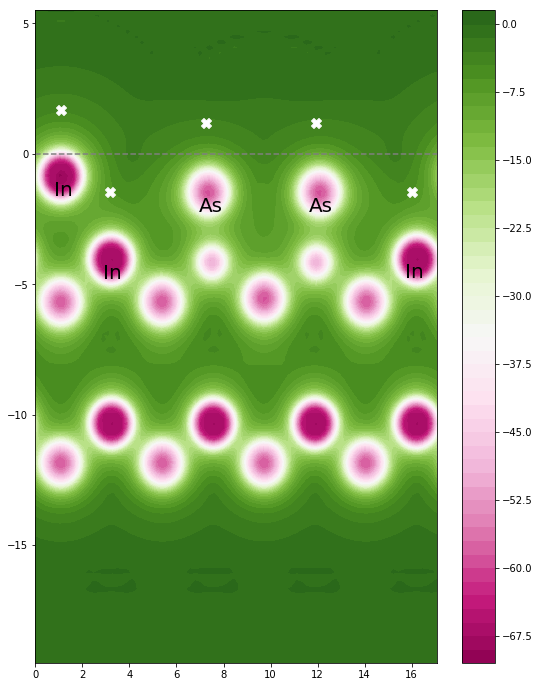

In [42]:
potentialplot('zeta_A_potential.cube',5,[5,2,3,20,23],5)

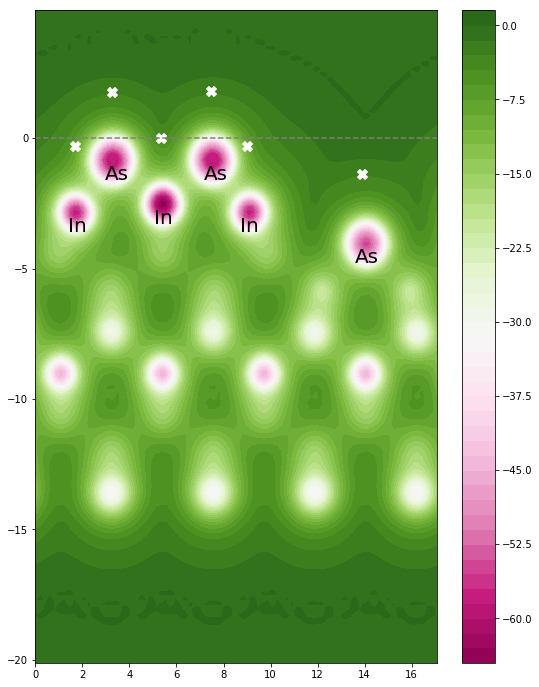

In [43]:
potentialplot('beta_2_potential.cube',9,[7,9,11,13,43,46],9)

In [368]:
atomxyz[5]

array([ 4.62641431,  1.07720689, 18.50657009])

In [388]:
view(betaatom)

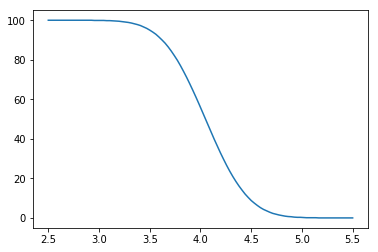

In [96]:
potentialrange = np.linspace(2.5,5.5,100)
zf = 3
vmax,Z0,Z =2.6,0,0
NFs=[]
for p in potentialrange:
    NFs.append(potential_NF(-p,vmax,zf,Z0,Z))
plt.plot(potentialrange,NFs)